In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [48]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import itertools
from os import path
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 13]
pd.options.display.width = 500
n_bins_default = 15
slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue'}

In [4]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        p = list(cache_dict['parameter_names'])
        return df, p

In [5]:
rename_dict = {
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr',
    'waypoint_start_time': 'start_time',
}
p = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
    'environment_name',
    'linear_update',
    'slam_node',
    'run_folder',
]
m = [
    'start_time',
    'norm_translation_error',
    'translation_error',
    'rotation_error',
    'trajectory_length',
    'tgs',
    'lvr',
]
df, params = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")

df = df[df.linear_angular_update == (0.5, 0.5)]
df = df[df.trajectory_length_trajectory_length > 1]

df.rename(columns=rename_dict, inplace=True)
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length

df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['norm_translation_error'] = df.translation_error / df.trajectory_length
df = df[p+m]

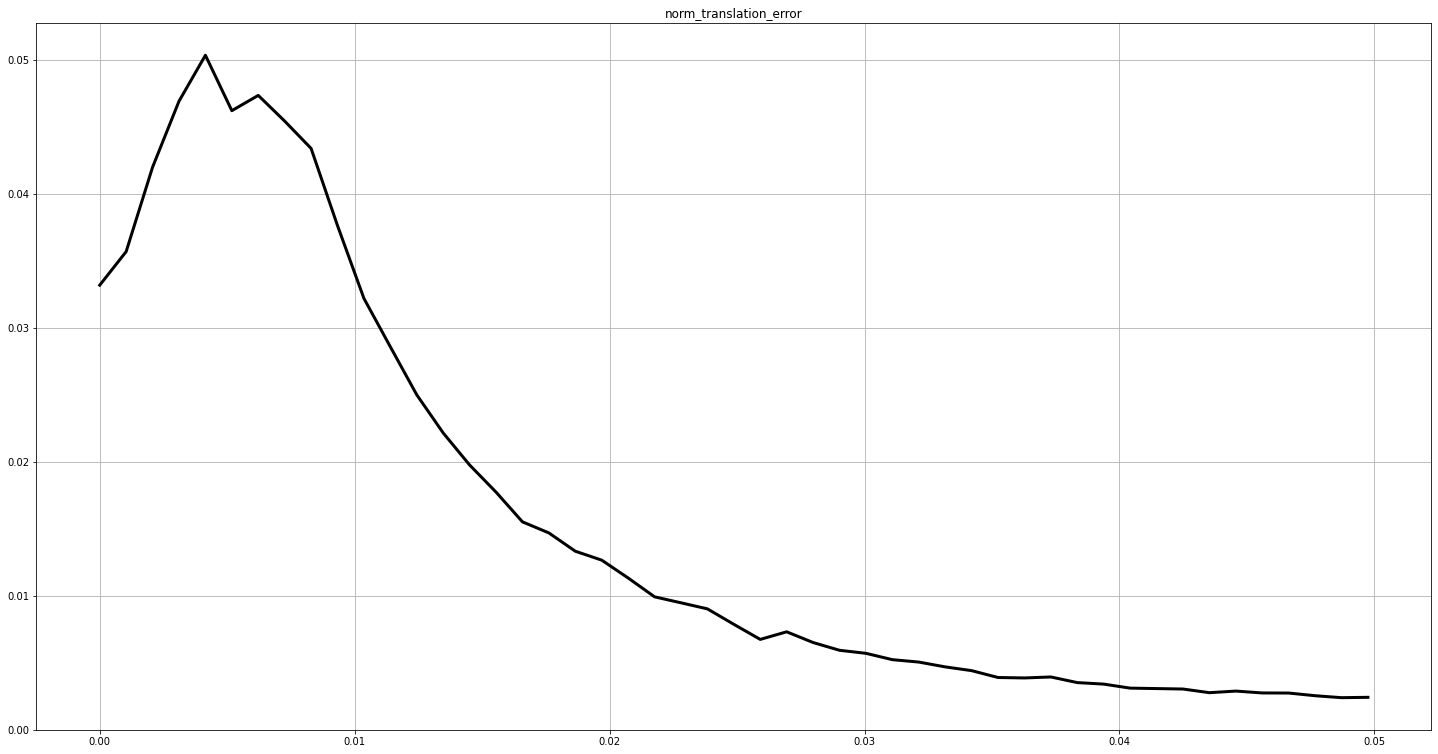

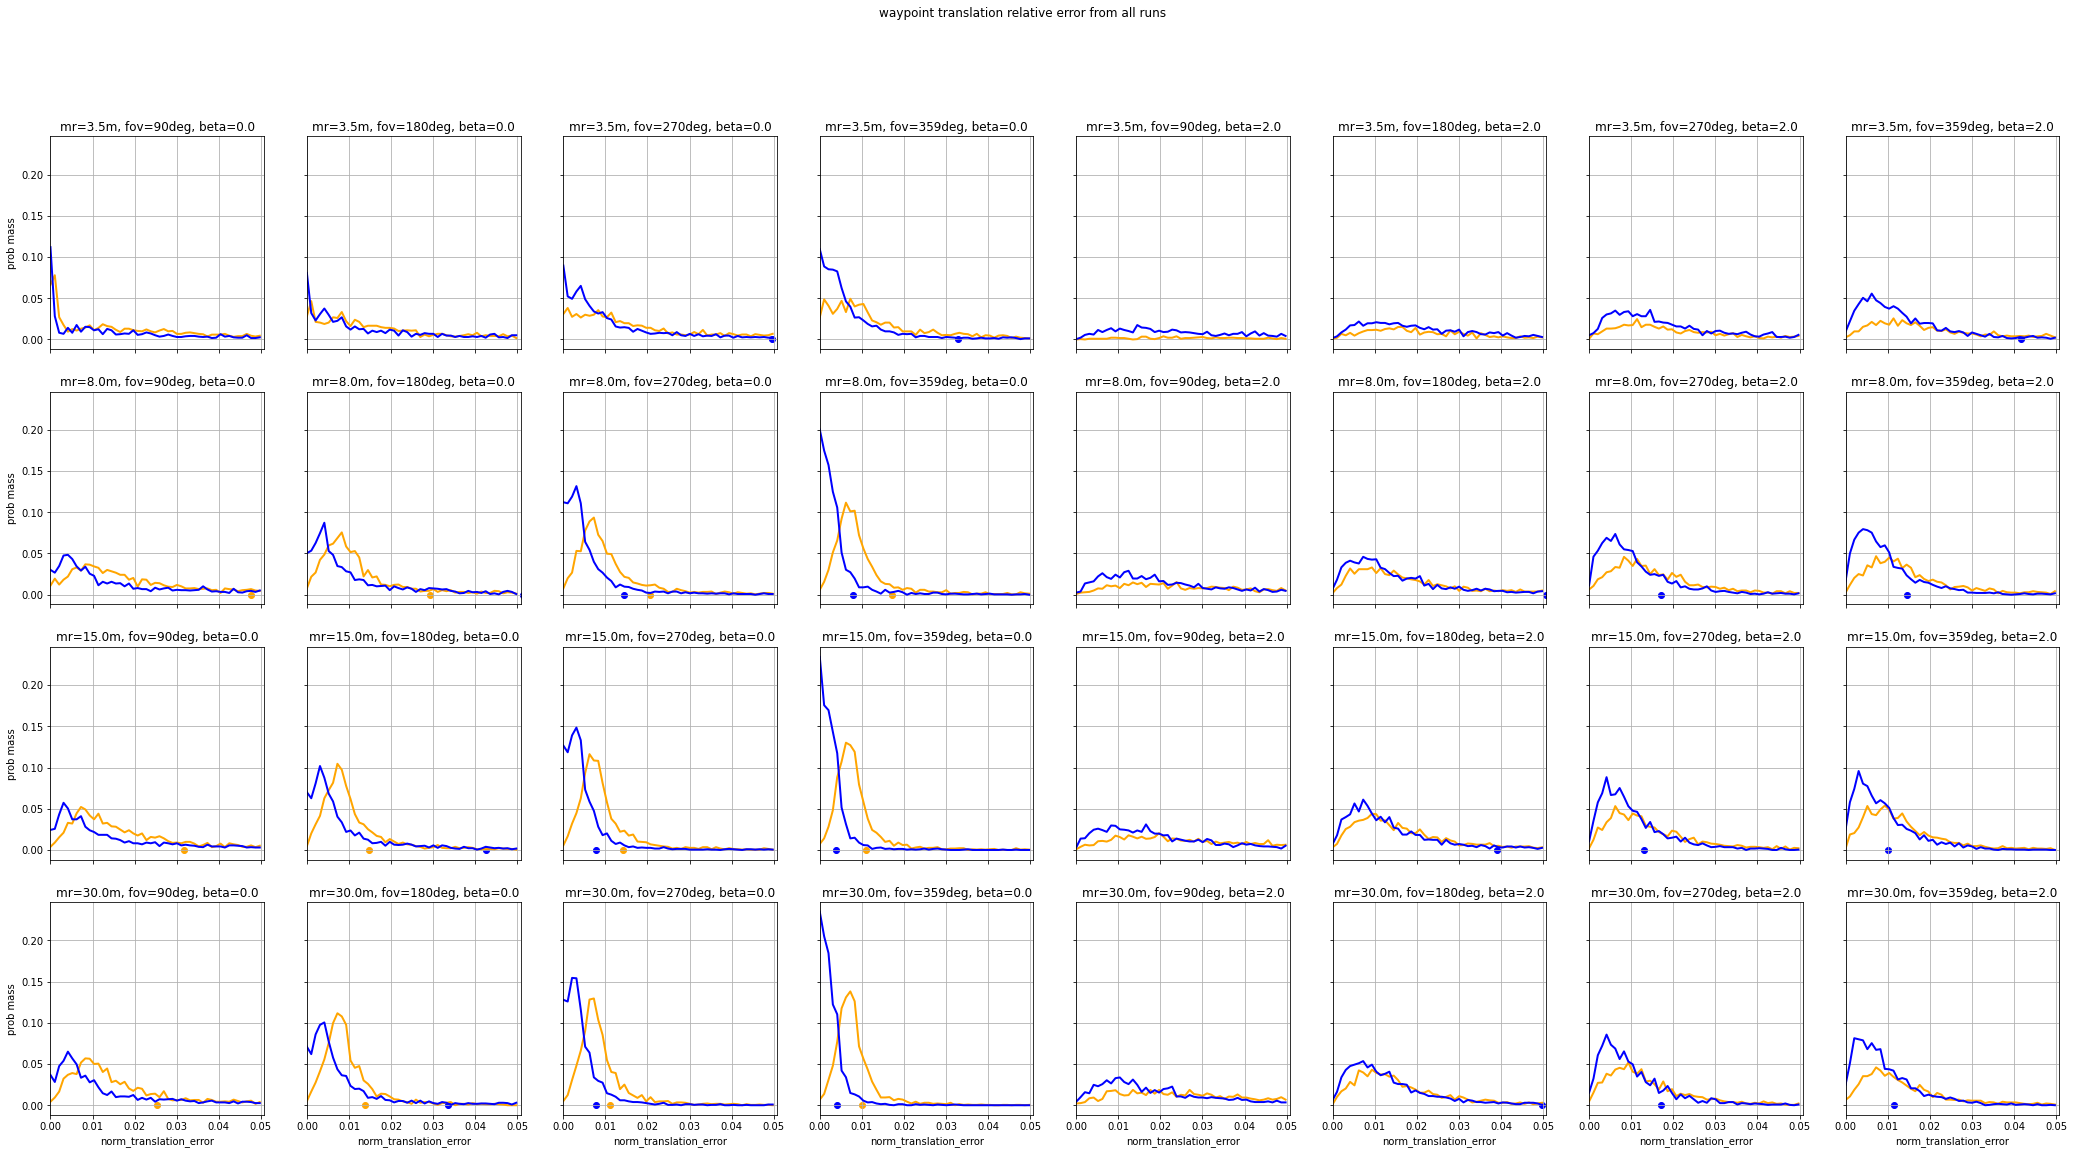

In [62]:
# slam_node = "slam_toolbox"
hist_metric = df.norm_translation_error

mean = hist_metric.mean()
# print("mean", mean)
# print("median", hist_metric.median())
# print(f"p({hist_metric.name} > mean)", len(df[hist_metric > mean]) / (len(df[hist_metric > mean]) + len(df[hist_metric < mean])))
# print(f"p({hist_metric.name} < mean)", len(df[hist_metric < mean]) / (len(df[hist_metric > mean]) + len(df[hist_metric < mean])))
# print(f"p({hist_metric.name} > 2)", len(df[hist_metric > 2]) / (len(df[hist_metric > 2]) + len(df[hist_metric < 2])))
# print(f"p({hist_metric.name} > 1)", len(df[hist_metric > 1]) / (len(df[hist_metric > 1]) + len(df[hist_metric < 1])))

x_lim_min = 0
x_lim_max = 0.5*mean

x = np.linspace(x_lim_min, x_lim_max, 50)
h_y, h_x = np.histogram(hist_metric, bins=x)
n = len(hist_metric)
plt.plot(h_x[:-1], h_y/n, linewidth=3, color="black")
plt.title(hist_metric.name)
plt.grid(True)
plt.show()

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

fig, axs = plt.subplots(len(mrs), len(betas_fovs))
fig.set_size_inches([36, 18])
for ax in axs.flat:
    ax.set(xlabel=hist_metric.name, ylabel='prob mass')
for ax in axs.flat:
    ax.label_outer()
for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
#         h_y, h_x = np.histogram(hist_metric, bins=x)
#         n = len(hist_metric)
#         axs[i, j].plot(h_x[:-1], h_y/n, linewidth=2, color="black")
        for slam_node in df.slam_node.unique():
            df_ = df[
                (df.slam_node == slam_node) &
                (df.laser_scan_max_range == mr) &
                (df.laser_scan_fov_deg == fov) &
                (df.beta == beta)
            ]
            h_y, h_x = np.histogram(df_[hist_metric.name], bins=x)
            n = len(df_[hist_metric.name])
            axs[i, j].plot(h_x[:-1], h_y/n, linewidth=2, color=slam_node_colors[slam_node])
            axs[i, j].scatter(df_[hist_metric.name].mean(), 0, color=slam_node_colors[slam_node])

        axs[i, j].set_title(f"mr={mr}m, fov={fov}deg, beta={beta}")
        
        axs[i, j].set_xlim(x_lim_min, x_lim_max)
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.grid(True)
plt.suptitle("waypoint translation relative error from all runs")
plt.show()

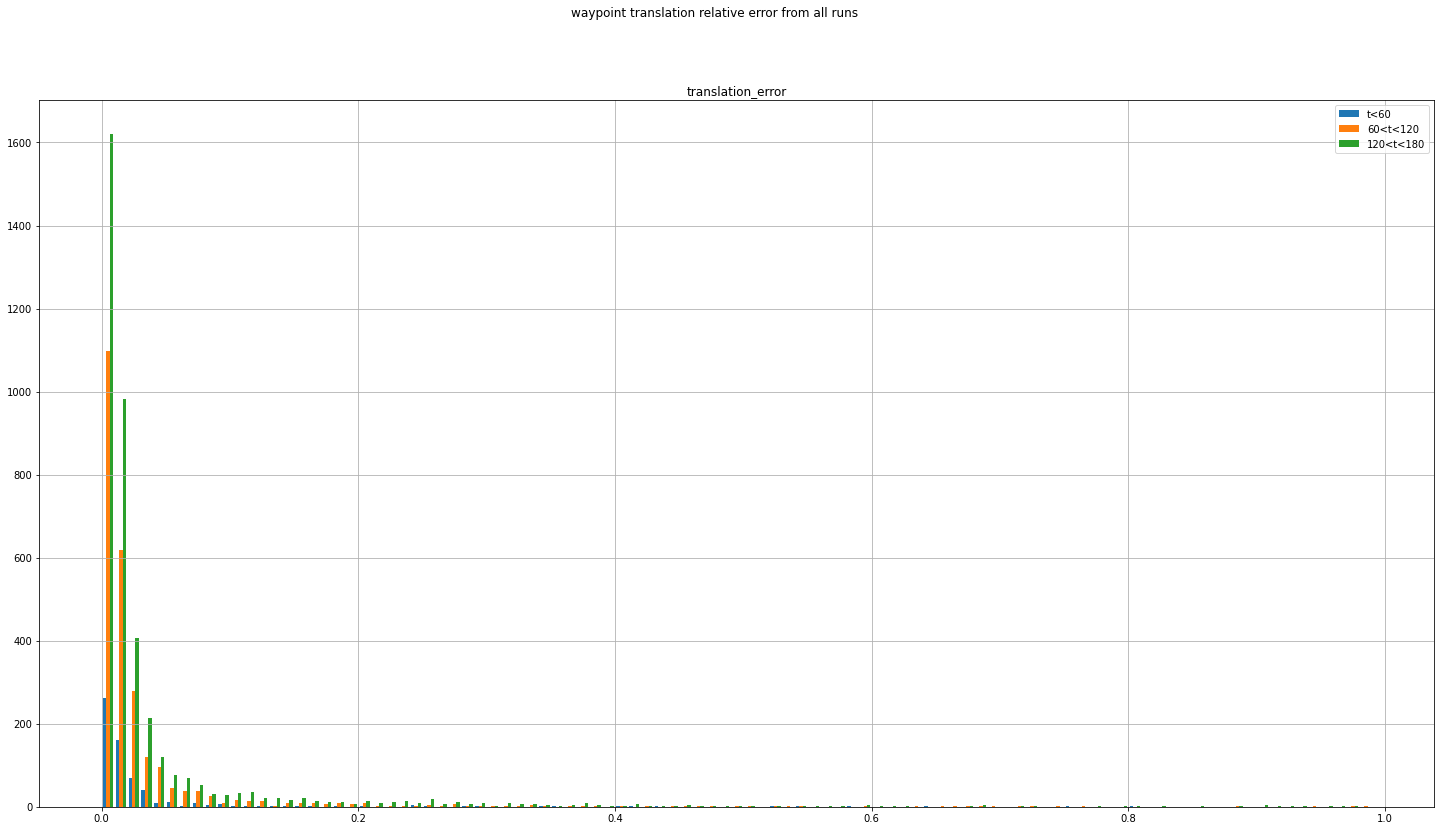

In [8]:
x = np.arange(0, 1.0, 0.01)
plt.hist(
    [
        df[df.start_time < 60].norm_translation_error, 
        df[(60 <= df.start_time) & (df.start_time < 120)].norm_translation_error,
        df[(120 <= df.start_time) & (df.start_time < 180)].norm_translation_error,
    ], 
    label=[
        't<60', 
        '60<t<120', 
        '120<t<180'
    ], 
    bins=x, )

# # plt.hist(df[(180 <= df.start_time) & (df.start_time < 40000)].norm_translation_error, bins=x, histtype='step', label='180<t')

plt.title("translation_error")
plt.grid(True)
plt.suptitle("waypoint translation relative error from all runs")
plt.legend()
plt.show()


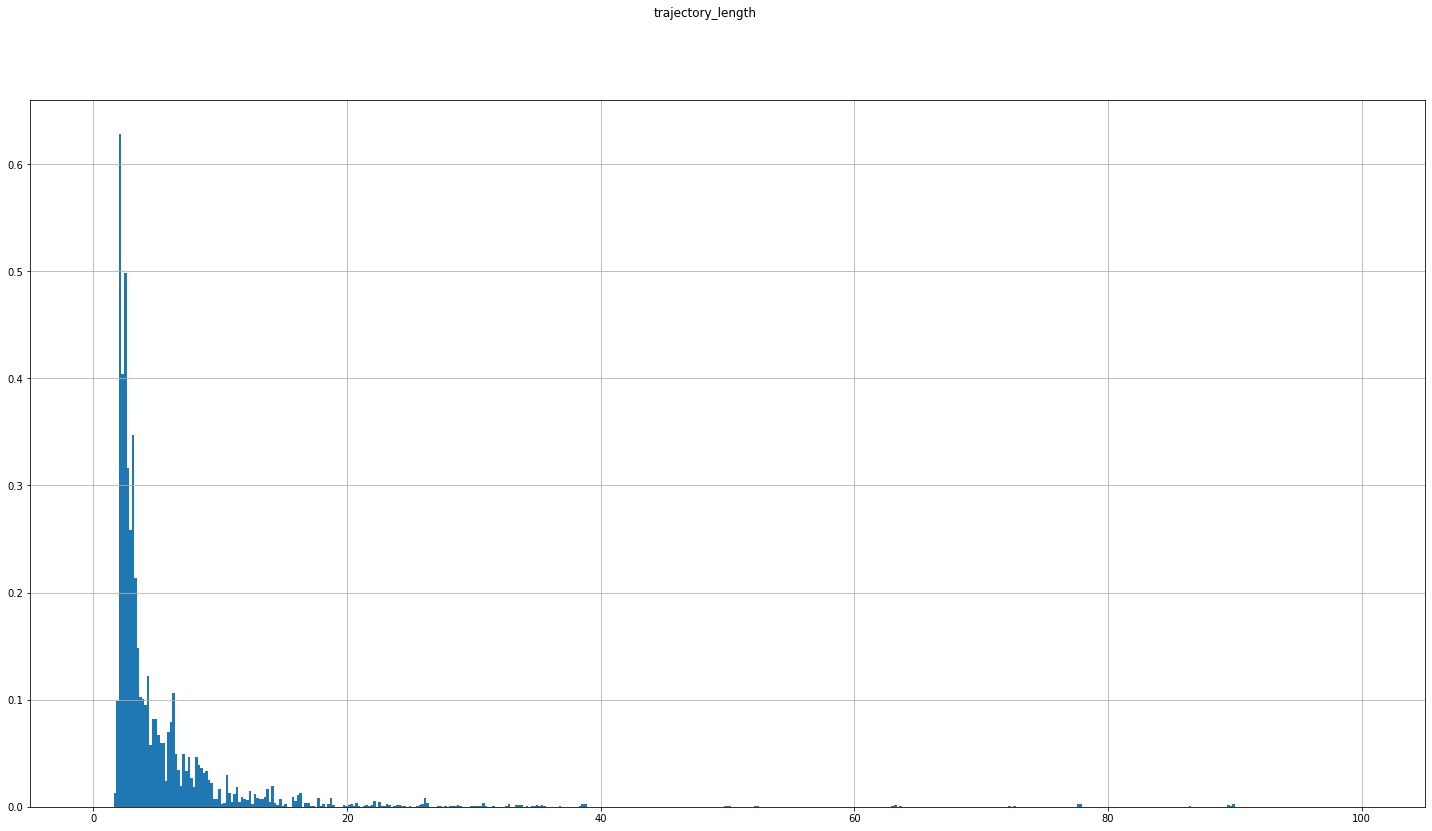

In [9]:
x = np.linspace(0, 100, 500)
plt.hist(df.trajectory_length, bins=x, density=True)

plt.grid(True)
plt.suptitle("trajectory_length")
plt.show()

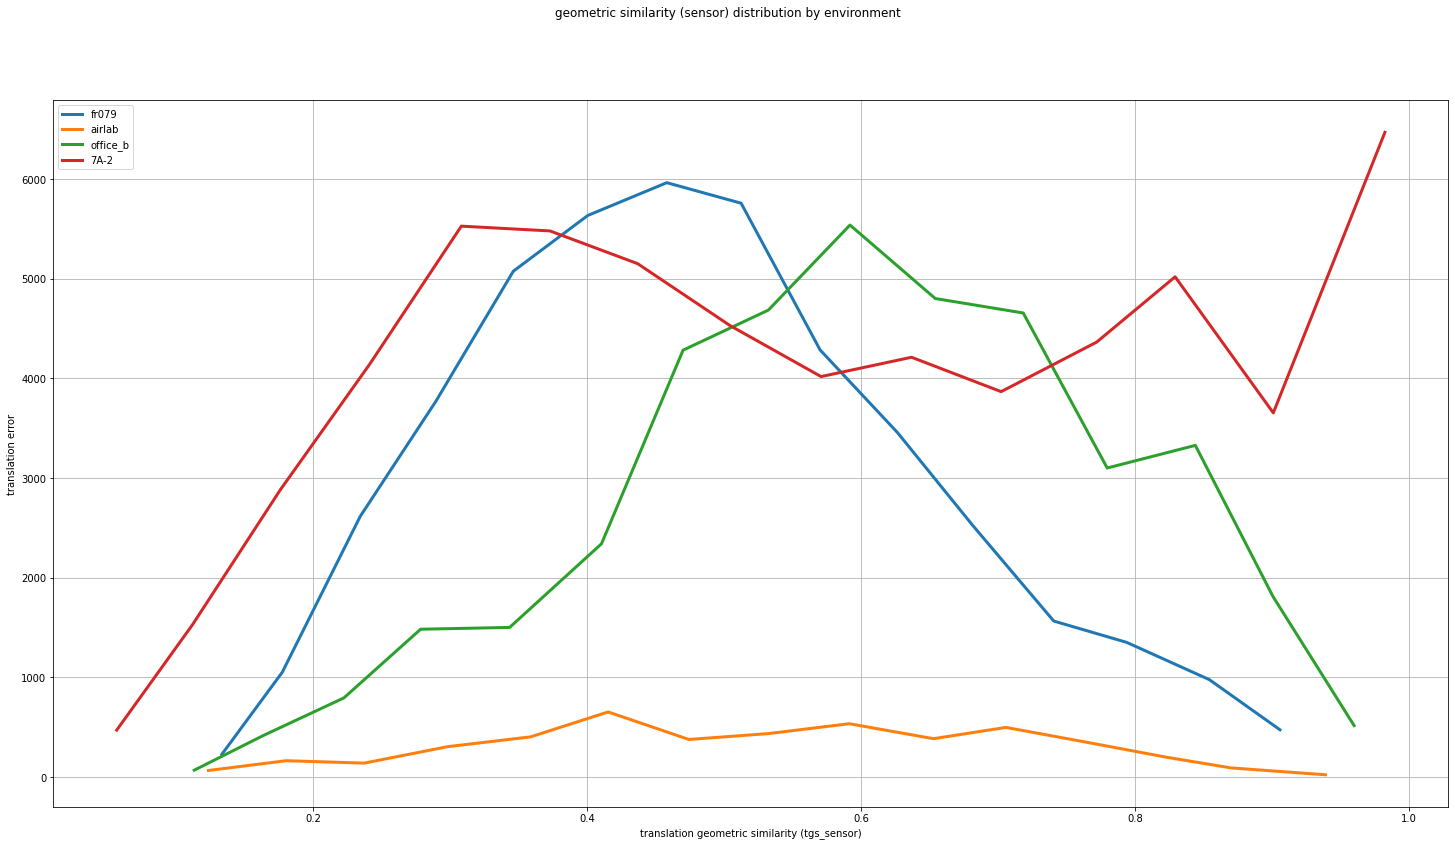

In [10]:
plt.xlabel('translation geometric similarity (tgs_sensor)') 
plt.ylabel('translation error')

for env_name in df.environment_name.unique():
    df_by_env = df[df.environment_name == env_name]
    df_by_env_bined = df_by_env.groupby(pd.cut(df_by_env.tgs, n_bins_default))
    df_hist = df_by_env_bined.agg(['mean', 'count'])
    plt.plot(
        df_hist[('tgs', 'mean')], 
        df_hist[('tgs', 'count')], 
        label=env_name, 
        linewidth=3)
plt.legend()
plt.grid(True)

plt.suptitle("geometric similarity (sensor) distribution by environment")
plt.show()

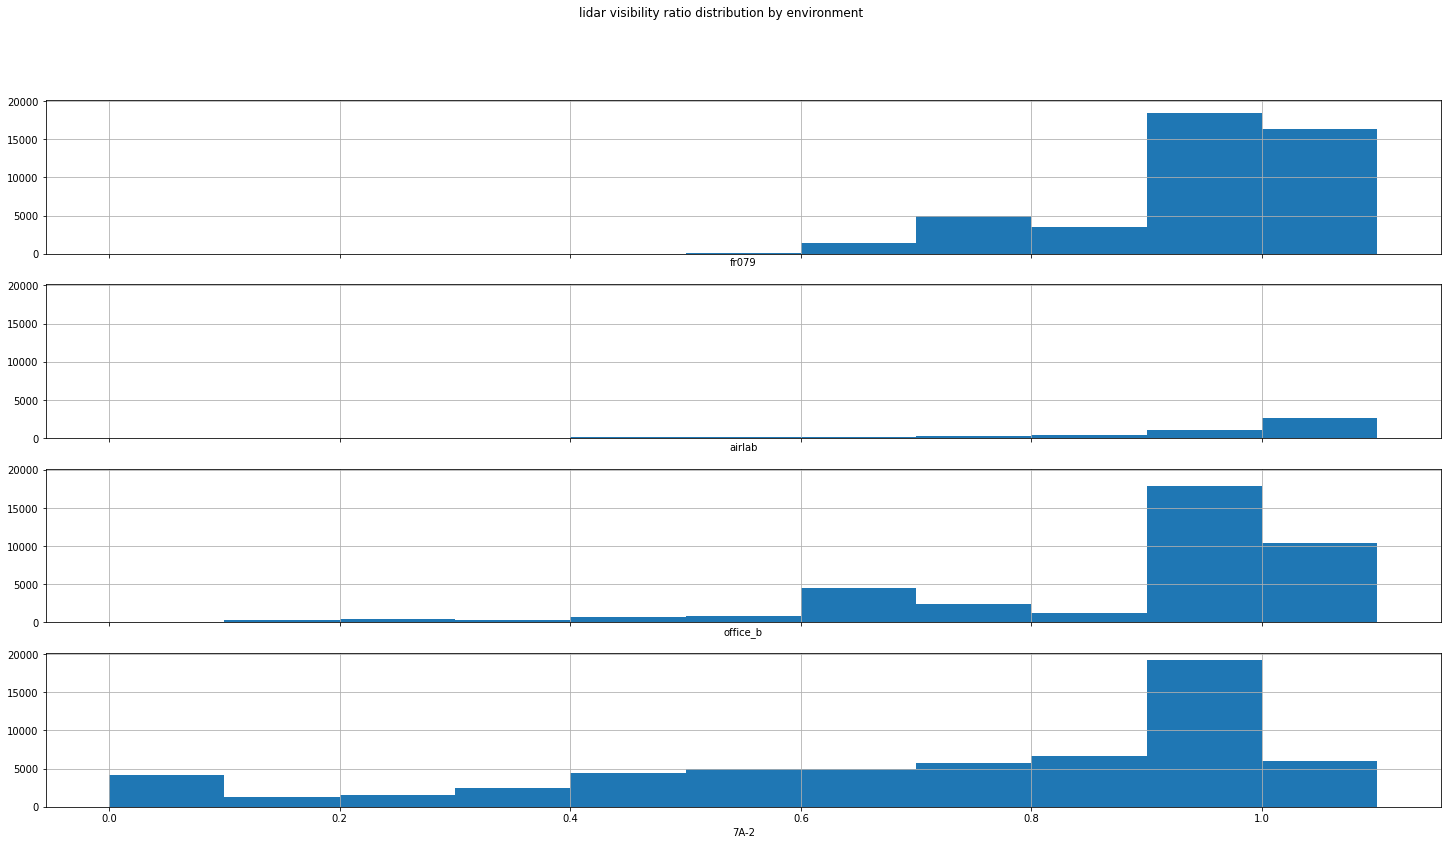

In [11]:
bins = list(np.arange(0.0, 1.2, 0.1))
env_names = df.environment_name.unique()

fig, axs = plt.subplots(len(env_names))
for ax in axs.flat:
    ax.label_outer()

for env_name, ax in zip(env_names, axs):
    df_by_env = df[df.environment_name == env_name]
    ax.hist(df_by_env.lvr, bins=bins)
    ax.set(xlabel=env_name)
    ax.sharex(axs[0])
    ax.sharey(axs[0])
    ax.grid(True)

plt.suptitle("lidar visibility ratio distribution by environment")
plt.show()